# 

`sdg4varselect` depends on `jax` library but also from `parametrization_cookbook`, this is not mandatory but strongly recommended all the examples will use a specific parametrization.

Let's start by importing all dependencies and the package :

In [373]:
import numpy as np

import jax.numpy as jnp
import jax.random as jrd

import functools
from jax import jit

import parametrization_cookbook.jax as pc
import sdg4varselect.plotting as sdgplt

### Mixed Effects Model Specification

We consider in this example the two compartments pharmacodynamic model used by Pinheiro and Bates (2000). The observation $Y_{i,j}$ is the serum concentration measured at time $t_{i,j}$. The model is given by:
$$Y_{ij} = \dfrac{D k_{ai}}{\mathcal V(k_{ai} - Cl_i)} 
\left( \exp\left(-\dfrac{Cl_i}{\mathcal V} t_{ij}\right) - \exp\left(-k_{ai} t_{ij}\right) \right) + \varepsilon_{ij}, ~
\varepsilon_{ij} \sim \mathcal N(0, \sigma^2).
$$
Where the individual’s parameters $V_i$ represents the distribution volume, $k_{ai}$ the absorption rate,  $Cl_i$  the clearance and $Cl_i/V_i$ the elimination rate; $D_i$ is the known dose of the drug received by individual  $i$.

Let define the individuals parameter using covariates to explain the individual variability : 
$$k_{ai} = \mu_1 +  X_i \beta_1+ \varphi_1,$$
$$Cl_i= \mu_2 +  X_i \beta_2 + \varphi_2,$$
where 
$$\varphi_i \sim \mathcal N_2\left(0, 
\begin{pmatrix}
\omega_1^2 & 0 \\
0 & \omega_2^2
\end{pmatrix}
\right),$$
We also define the non linear function $m$ that define the mixed model : 
$$
    m(t_{ij},V_i, k_{ai}, Cl_i) = \frac{D_i k_{ai}}{V_i(k_{ai} - Cl_i/V_i)} \left(\exp(-k_{ai}t_{ij}) - \exp\left(-\frac{Cl_i}{V_i}t_{ij}\right)\right).
$$

We define this function in the following code : 

In [374]:
def m(params, times, D, V, ka, Cl, **kwargs):
    out = (
        D
        * ka[:, None]
        / (V * ka[:, None] - Cl[:, None])
        * (jnp.exp(-Cl[:, None] / V * times) - jnp.exp(-ka[:, None] * times))
    )

    assert out.shape == times.shape
    return out

we define the individuals parameters with the function : 

In [375]:
def individual_parameters(self, params, **kwargs) -> jnp.ndarray:
    cov1 = kwargs["cov1"]
    cov2 = kwargs["cov2"]

    mean = jnp.array([params.mean_latent.mu1, params.mean_latent.mu2])
    return mean + jnp.array([cov1 @ params.beta1, cov2 @ params.beta2]).T

We can now define our models as follows. We define a new python class inherited from the `AbstractMixedEffectsModel` class. This implements the minimal structure to define a model from only the function that we have just implemented.

We also want to define a high dimensional covariate model, we inherit from the `AbstractHDModel` class for this.

In [376]:
from sdg4varselect.models import AbstractMixedEffectsModel, AbstractHDModel


class PKMixedEffectsModel(AbstractMixedEffectsModel, AbstractHDModel):
    def __init__(self, N=1, P=1, **kwargs):
        AbstractHDModel.__init__(self, P=P)
        AbstractMixedEffectsModel.__init__(self, N=N, J=12, **kwargs)
        self.add_latent_variables("ka")
        self.add_latent_variables("Cl")

    @property
    def name(self):
        return f"PKMEM_N{self.N}_J{self.J}_P{self.P}"

    def init_parametrization(self):
        self._parametrization = pc.NamedTuple(
            mean_latent=pc.NamedTuple(
                mu1=pc.Real(loc=10, scale=1),
                mu2=pc.Real(loc=10, scale=1),
            ),
            cov_latent=pc.MatrixDiagPosDef(dim=2, scale=1),
            var_residual=pc.RealPositive(scale=0.01),
            beta1=pc.Real(scale=1, shape=(self.P // 2,)),
            beta2=pc.Real(scale=1, shape=(self.P // 2,)),
        )
        self.parametrization_size = self._parametrization.size

    # ============================================================== #
    @functools.partial(jit, static_argnums=0)
    def mixed_effect_function(self, params, *args, **kwargs) -> jnp.ndarray:
        return m(params, *args, **kwargs)

    # ============================================================== #
    @functools.partial(jit, static_argnums=0)
    def get_mean_latent(self, params, **kwargs) -> jnp.ndarray:
        return individual_parameters(self, params, **kwargs)

    # ============================================================== #

    def sample(self, params_star, prngkey, **kwargs):
        (prngkey_cov, prngkey_mem) = jrd.split(prngkey, num=2)

        time = jnp.array([0.05, 0.15, 0.25, 0.4, 0.5, 0.8, 1, 2, 7, 12, 24, 40])
        self._j = time.shape[0]
        time = jnp.tile(time, (self.N, 1))

        cov = jrd.bernoulli(prngkey_cov, p=0.2, shape=(self.N, self.P // 2))
        cov /= jnp.std(cov, axis=0)[None, :]
        cov -= jnp.mean(cov, axis=0)[None, :]

        obs, sim = AbstractMixedEffectsModel.sample(
            self,
            params_star,
            prngkey_mem,
            mem_obs_time=time,
            cov1=cov,
            cov2=cov[:, :],
        )

        return {"mem_obs_time": time, "cov1": cov, "cov2": cov[:, :]} | obs, sim

### Data Generation

Let's generat one data set with $200$ individuals, first we define the true parameter values.

In [377]:
myModel = PKMixedEffectsModel(N=300, P=500 * 2, D=100, V=30)

beta_star = (
    jnp.zeros(shape=(2, myModel.P // 2))
    .at[:, :5]  #
    .set([[3, 2, 1, 0, 0], [0, 0, 3, 2, 1]])  #
)

p_star = myModel.new_params(
    mean_latent={"mu1": 6, "mu2": 8},
    cov_latent=jnp.diag(jnp.array([0.2, 0.1])),
    var_residual=1e-3,
    beta1=beta_star[0, :],
    beta2=beta_star[1, :],
)
p_names = np.array(
    ["$\\mu_1$", "$\\mu_2$"]
    + [f"$\\omega^2_{{{i//(2)},{i%(2)}}}$" for i in range(2**2)]
    + ["$\\sigma^2$"]
    + [f"$\\beta_{{1,{i}}}$" for i in range(myModel.P // 2)]
    + [f"$\\beta_{{2,{i}}}$" for i in range(myModel.P // 2)],
)

Then we can generate a data set :

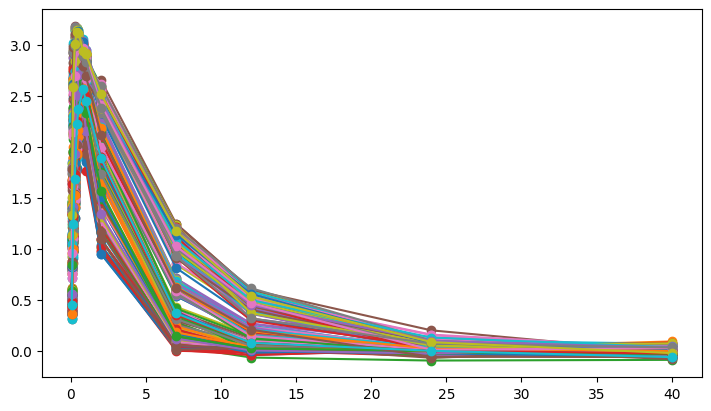

In [378]:
myobs, mysim = myModel.sample(p_star, jrd.PRNGKey(0))
_ = sdgplt.ax(4, 7).plot(myobs["mem_obs_time"].T, myobs["Y"].T, "o-")

# Selection and re Estimation Procedure

In order to perform variable selection on the covariates and an estimation of the parameter, we use the Stochastic Proximal Gradient Descent using adaptive stepsize define by the Adagrad algorithm.

In [ ]:
from sdg4varselect.algo import (
    preconditioner_factory,
    StochasticProximalGradientDescentPrecond as SPGD,
)

AdaGrad = preconditioner_factory("AdaGrad", scale=None, regularization=1e-8)

algo = SPGD(AdaGrad, partial_fit=False)
algo.init_mcmc(myModel, adaptative_sd=True)

algo.max_iter = 2000
algo.estimate_average_length = 500

To plot the estimates during the iterations, we need to enable saving of all algorithm data

In [380]:
algo.save_all = True

We finally define a function which, for a random seed and a regularization value, performs a selection of the most relevant covariates and then a re-estimation in the model reduced to the selected covariates.

In [381]:
def selection(algo, prngkey, model, data, lbd):

    prngkey_theta, prngkey_select, prngkey_estim = jrd.split(prngkey, 3)

    theta0 = (
        jrd.normal(prngkey_theta, shape=(model.parametrization.size,))
        # .at[2:4]
        # .set(jnp.array([2.0e-01, 1.0e-01]) * 10)
    )
    algo._preconditioner._scale = jnp.concatenate(
        [
            2 * jnp.ones(shape=(2,)),
            2 * jnp.ones(shape=(2,)),
            1 * jnp.ones(shape=(1,)),
            2 * jnp.ones(myModel.P),
        ]
    )

    algo.set_seed(prngkey_select)
    algo.lbd = lbd
    out = algo.fit(model, data, theta0)

    return out

    supp = (out.last_theta != 0).at[: -model.P].set(True)

    t0 = jnp.concatenate(
        [
            # out.last_theta_reals1d[:-P],
            theta0[:-P],
            # jnp.where(supp[-P:], out.last_theta_reals1d[-P:], 0),
            jnp.where(supp[-P:], theta0[-P:], 0),
        ]
    )

    estimation = _one_estim(
        algo_estim,
        t0,
        prngkey_estim,
        model,
        data,
        lbd=None,
        freeze=jnp.zeros(shape=t0.shape, dtype=jnp.bool).at[-P:].set(~supp[-P:]),
    )
    out += estimation
    return out

We evaluate this function on a grid of regularization values ​​using the function provided by the package. We thus construct a regularization path

In [382]:
from sdg4varselect._regularization_function import regularization_path

x = regularization_path(
    selection,
    prngkey=jrd.PRNGKey(0),
    lbd_set=jnp.logspace(-1, 1, num=3),
    algo=algo,
    model=myModel,
    data=myobs,
)
x.theta_star = p_star

/home/acaillebotte/projects/packages/sdg4varselect/sdg4varselect/algo/sto_grad_descent_precond.py:167: UserWarning: 
The algorithm may not have converged, 3 components of the gradient of the log marginal likelihood are not sufficiently small
  warnings.warn(
/home/acaillebotte/projects/packages/sdg4varselect/sdg4varselect/algo/sto_grad_descent_precond.py:167: UserWarning: 
The algorithm may not have converged, 3 components of the gradient of the log marginal likelihood are not sufficiently small
  warnings.warn(
/home/acaillebotte/projects/packages/sdg4varselect/sdg4varselect/algo/sto_grad_descent_precond.py:167: UserWarning: 
The algorithm may not have converged, 3 components of the gradient of the log marginal likelihood are not sufficiently small
  warnings.warn(


We can observe and verify the good convergence of the algorithm for the different regularization values

/home/acaillebotte/projects/packages/sdg4varselect/sdg4varselect/outputs.py:503: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="center left")


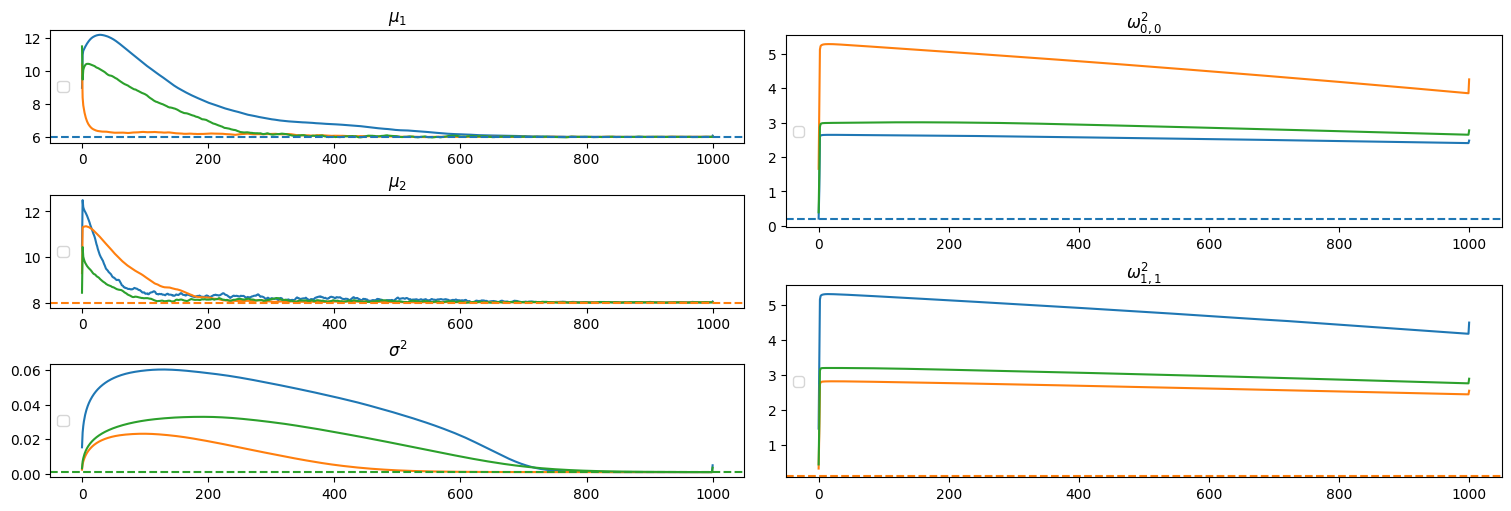

In [383]:
fig = sdgplt.figure(5, 15)
_ = sdgplt.plot_theta(
    x,
    fig=[*fig.subfigures(1, 2)],
    params_names=p_names,
    id_to_plot=[
        [0, 1, 6],
        [2, 5],  # 3, 4,
    ],
    log_scale=False,
)

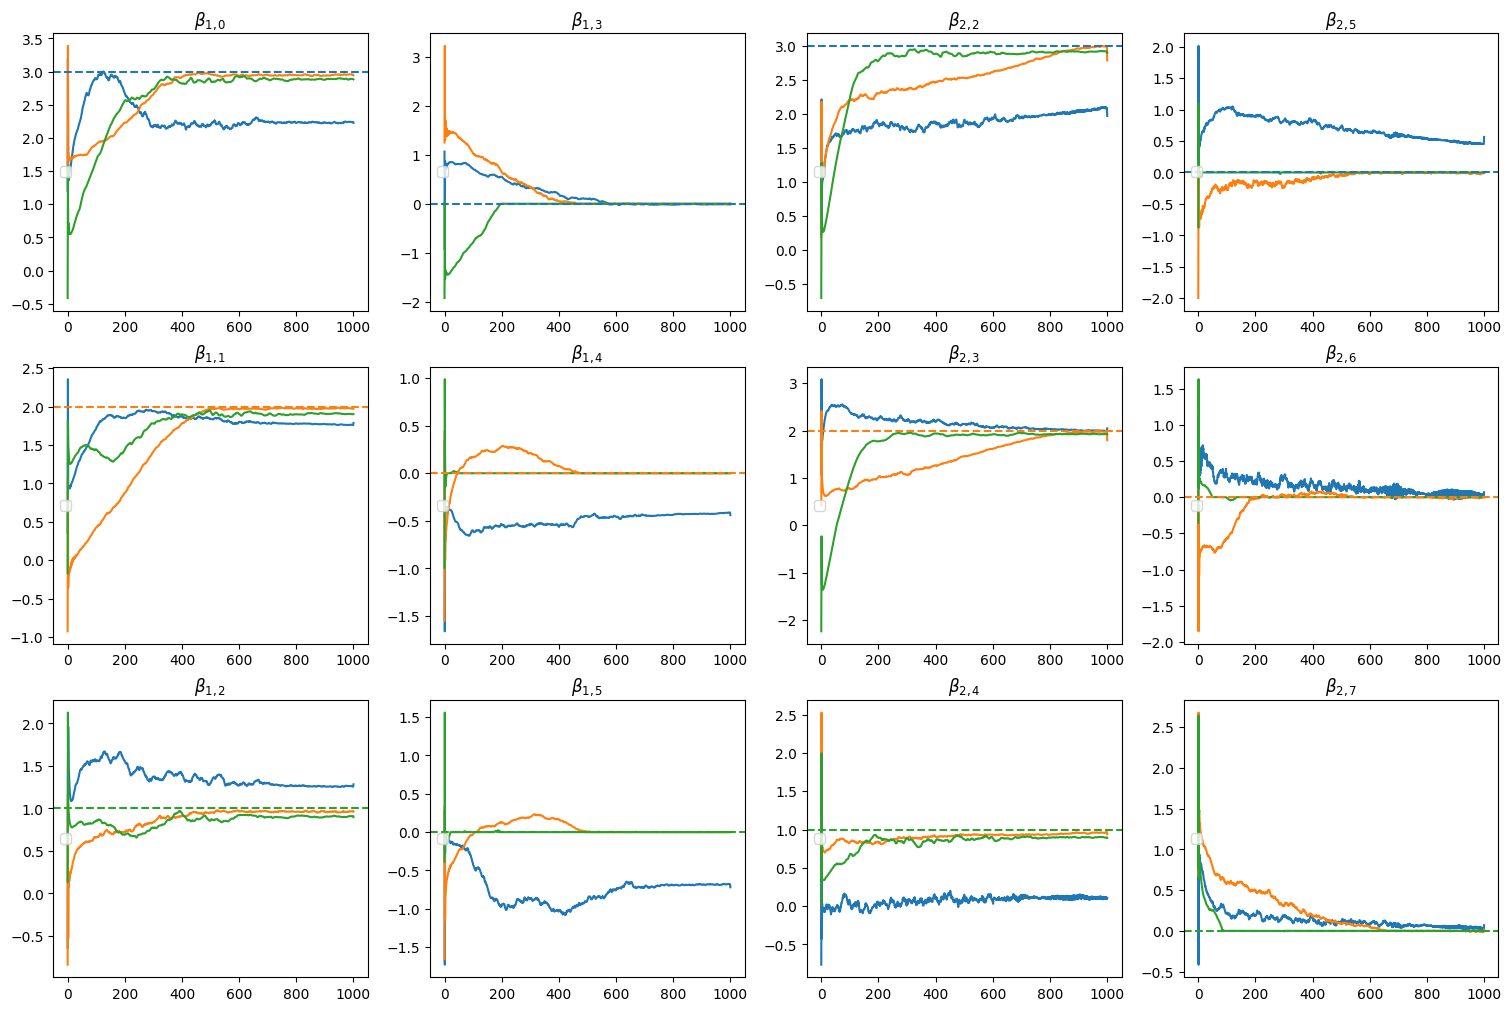

In [384]:
fig = sdgplt.figure(10, 15)
_ = sdgplt.plot_theta(
    x,
    fig=[*fig.subfigures(1, 4)],
    params_names=p_names,
    id_to_plot=[
        [7, 8, 9],
        [10, 11, 12],
        [9 + myModel.P // 2, 9 + myModel.P // 2 + 1, 9 + myModel.P // 2 + 2],
        [9 + myModel.P // 2 + 3, 9 + myModel.P // 2 + 4, 9 + myModel.P // 2 + 5],
    ],
    log_scale=False,
)

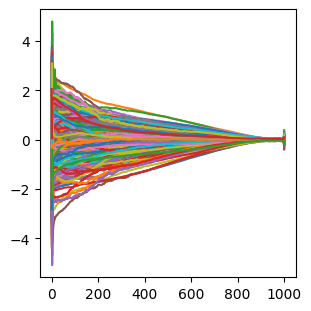

In [385]:
ax = sdgplt.ax(3, 3)
_ = ax.plot(x.theta[1, :, 10 : 9 + myModel.P // 2])
_ = ax.plot(x.theta[1, :, 9 + myModel.P // 2 + 3 :])

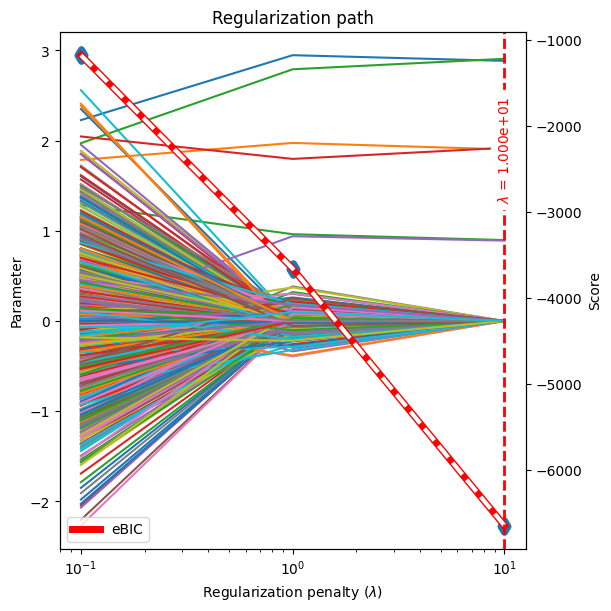

In [386]:
fig = sdgplt.figure(6, 6)
fig = sdgplt.plot_regpath(x, P=myModel.P, fig=fig)
_ = fig.axes[1].legend(loc="best")
_ = fig.axes[1].scatter(x.lbd_set, x.ebic, marker="d", linewidths=5)

The non-zeros parameters are recover